### Colinearidade

O RDKit nos permite calcular 200 descritores 2D para descrever estruturas químicas. Alguns pacotes permitem o cálculo de ainda mais descritores. Dessa forma, é natural que alguns pares desses descritores sejam colineares. Isso quer dizer que, se fizermos um gráfico com os valores de um descritor no eixo x e de outro no eixo y, obteremos uma reta.

Como exemplo, vamos usar o banco de dados de Delaney e verificar a relação entre os descritores `MolWt` e `ExactMolWt` do RDKit, que correspondem à massa molecular relativa e massa molecular relativa exata, respectivamente.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv("Delaney_descriptors.csv", sep=";")
df.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Solubilidade_medida
0,10.253329,-1.701605,10.253329,0.486602,0.217518,457.432,430.216,457.158411,178,0,...,0,0,0,0,0,0,0,0,0,-0.77
1,11.724911,-0.145880,11.724911,0.145880,0.811283,201.225,190.137,201.078979,76,0,...,0,0,0,0,0,0,0,0,0,-3.30
2,10.020498,0.845090,10.020498,0.845090,0.343706,152.237,136.109,152.120115,62,0,...,0,0,0,0,0,0,0,0,0,-2.06
3,2.270278,1.301055,2.270278,1.301055,0.291526,278.354,264.242,278.109550,102,0,...,0,0,0,0,0,0,0,0,0,-7.87
4,2.041667,1.712963,2.041667,1.712963,0.448927,84.143,80.111,84.003371,26,0,...,0,0,0,0,0,0,1,0,0,-1.33


In [3]:
df[["MolWt","ExactMolWt"]]

,MolWt,ExactMolWt
0,457.432,457.158411
1,201.225,201.078979
2,152.237,152.120115
3,278.354,278.109550
4,84.143,84.003371
...,...,...
1123,197.381,195.890224
1124,219.266,219.067762
1125,246.359,245.997179
1126,72.151,72.093900


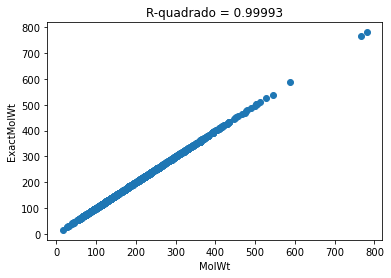

In [4]:
## Cálculo do coeficiente de correlação R²
r2 = str(r2_score(df["MolWt"], df["ExactMolWt"]).round(5))

## Gráfico
plt.scatter(df["MolWt"], df["ExactMolWt"])
plt.xlabel("MolWt")
plt.ylabel("ExactMolWt")
plt.title(f"R-quadrado = {r2}")
plt.show()

Vemos que esses dois descritores são praticamente idênticos. Isso é de se esperar, pois os valores diferem apenas nas casas decimais. 

Imagine agora que fôssemos treinar um modelo preditivo e que esses dois descritores estivessem presentes. Na melhor das hipóteses, nosso modelo usaria apenas um deles, e reconheceria o outro como sendo irrelevante. Porém, nem sempre isso ocorre, e existe a possibilidade de que a presença de variáveis correlacionadas introduza instabilidade aos modelos. 

Como exemplo, vamos demonstrar o valor dos coeficientes de uma regressão linear contendo os dois descritores, e uma regressão na qual não usamos o descritor ExactMolWt. Para mais detalhes sobre esse tipo de análise, veja o Notebook sobre Importância de Atributos.

In [5]:
# Vamos selecionar apenas algumas colunas para possibilitar uma melhor visualização dos coeficientes
# X = df[['MolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumHAcceptors',
#          'NumHDonors', 'NumSaturatedRings', 'MolLogP', 'MolMR']]
X = df[["MolWt", "ExactMolWt", "FractionCSP3", "MolLogP", "NumAromaticRings", "NumHAcceptors", 
        "NumHDonors", "NumRotatableBonds", "TPSA", "LabuteASA"]]
y = df.iloc[:, -1]  # resposta

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [7]:
# Padronizando os dados
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

# Regressão linear com MolWt e ExactMolWt = colinearidade
reg1 = LinearRegression()
reg1.fit(X, y)
ypred1 = reg1.predict(X)
imp1 = reg1.coef_

# Regressão linear removendo ExactMolWt
new_X = X.drop(["ExactMolWt"], axis=1)
reg2 = LinearRegression()
reg2.fit(new_X, y)
ypred2 = reg2.predict(new_X)
imp2 = reg2.coef_

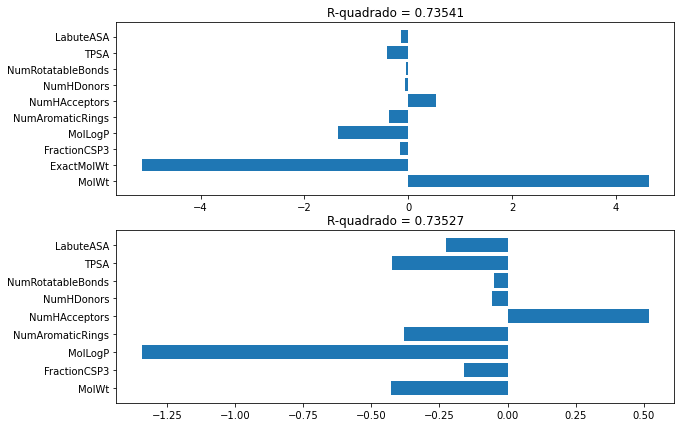

In [8]:
# Gráficos com os valores dos coeficientes
plt.figure(figsize=(10,7))

plt.subplot(2, 1, 1)
plt.barh(X.columns, imp1)
plt.title(f"R-quadrado = {str(r2_score(ypred1, y).round(5))}")

plt.subplot(2, 1, 2)
plt.barh(new_X.columns, imp2)
plt.title(f"R-quadrado = {str(r2_score(ypred2, y).round(5))}")

plt.show()

Veja que os coeficientes de MolWt e ExactMolWt são muito grandes, praticamente do mesmo tamanho, e de sinais opostos. Ou seja, podemos acreditar que ambos são muito importantes para descrever nossa variável. Porém, quando retiramos um deles, vemos que a importância do outro no modelo é, na verdade, muito menor do que antes. Portanto, concluímos que **é uma boa prática remover variáveis correlacionadas antes de criar modelos de ML**.

Uma forma de fazer isso é calculando a correlação entre todos os pares de variáveis. Vejamos como fazer isso:

In [9]:
# Verificando a existência de variáveis altamente correlacionadas
from itertools import combinations

corr_matrix = X.corr()
comb = combinations(corr_matrix.columns, 2)
for c1, c2 in comb:
    if abs(corr_matrix.loc[c1, c2]) > 0.8:
        print(f'r2 (módulo) entre as variáveis {c1} e {c2} = {corr_matrix.loc[c1, c2]:.3f}')

r2 (módulo) entre as variáveis MolWt e ExactMolWt = 1.000
r2 (módulo) entre as variáveis MolWt e LabuteASA = 0.970
r2 (módulo) entre as variáveis ExactMolWt e LabuteASA = 0.971
r2 (módulo) entre as variáveis NumHAcceptors e TPSA = 0.897


Verificamos que existem algumas variáveis altamente correlacionadas. Dessa forma, podemos remover `ExactMolWt` e `LabuteASA`, já que são colineares com `MolWt`, e `TPSA`, que é correlacionada com `NumHAcceptors`.

In [10]:
X.drop(["ExactMolWt", "LabuteASA", "TPSA"], axis=1, inplace=True)
X.head()

,MolWt,FractionCSP3,MolLogP,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds
0,2.468485,0.548553,-2.999665,0.068826,4.594037,5.782689,1.826914
1,-0.026410,-0.963310,0.212089,1.064158,-0.051896,0.274281,-0.067166
2,-0.503445,0.148354,0.232434,-0.926505,-0.516489,-0.643787,0.690466
3,0.724658,-1.185643,2.079789,4.050152,-0.981083,-0.643787,-0.824798
4,-1.166532,-1.185643,-0.377645,0.068826,-0.516489,-0.643787,-0.824798


Com isso, nosso conjunto de dados está adequado para a criação de um modelo preditivo.